<a href="https://colab.research.google.com/github/CheesyPotato77/Casting_Product_Defect_Detection/blob/main/Casting_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'real-life-industrial-dataset-of-casting-product:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F487456%2F1300891%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T053708Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D42c715f3c85228661697c60786fe084fddd24f3d2fe61fe7df03708666df633391a6a1b0c3b14e1efc562e293745b3f11e826f3588c0c88e7b8124b80b623d6a1f5f02d1cd445367d1c8140f5501f24575578239145828a2891e356c4420bde2ec37ac9c46c36c7828b07e2203194ef03241a4939de1a1a115a03bf3ad2bbcde8274c7077e896558e02516cedfb52b588ed1432955b2322873e580ac5261166f094b67060043c93cb3870eb8870f60e023d9b0244da4126153f7f95d432a5cb3813252835556968d6c80ab80247e80e883e312c8eb6f44bd818278b78429b1cae47bbafb778f90295b1de52b1fd827aea347f31a8b75fd61ddfd4903602820a7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 104965698 bytes downloaded
Downloaded and uncompressed: real-life-industrial-dataset-of-casting-product
Data source import complete.


In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Streaming output truncated to the last 5000 lines.
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_3250.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_4008.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_6495.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_3043.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_4725.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_8616.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_4165.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data

In [ ]:
train_dir = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train'
test_dir = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/test'

# Data Proprecessing

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)


test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32, 2)


In [ ]:
# Check class names
class_names = train_data.class_indices
class_names = list(class_names.keys())
print(class_names)

['def_front', 'ok_front']


In [ ]:
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names[label_index]

    return image, label_name


def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

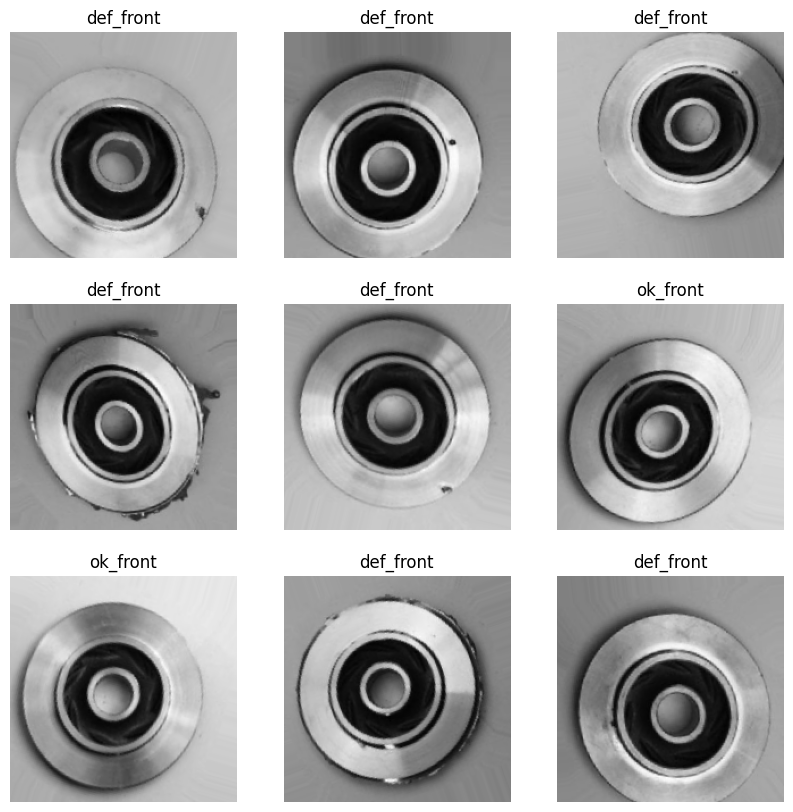

In [ ]:
sample_images(train_data, nrows=3, ncols=3)

In [ ]:
image_batch

array([[[[0.575666  , 0.575666  , 0.575666  ],
         [0.5753639 , 0.5753639 , 0.5753639 ],
         [0.57506174, 0.57506174, 0.57506174],
         ...,
         [0.61960787, 0.61960787, 0.61960787],
         [0.62379235, 0.62379235, 0.62379235],
         [0.63264596, 0.63264596, 0.63264596]],

        [[0.57957596, 0.57957596, 0.57957596],
         [0.5792738 , 0.5792738 , 0.5792738 ],
         [0.5789716 , 0.5789716 , 0.5789716 ],
         ...,
         [0.61903703, 0.61903703, 0.61903703],
         [0.62605655, 0.62605655, 0.62605655],
         [0.63201815, 0.63201815, 0.63201815]],

        [[0.5803922 , 0.5803922 , 0.5803922 ],
         [0.5803922 , 0.5803922 , 0.5803922 ],
         [0.5803922 , 0.5803922 , 0.5803922 ],
         ...,
         [0.6242734 , 0.6242734 , 0.6242734 ],
         [0.6282423 , 0.6282423 , 0.6282423 ],
         [0.628787  , 0.628787  , 0.628787  ]],

        ...,

        [[0.72156864, 0.72156864, 0.72156864],
         [0.72156864, 0.72156864, 0.72156864]

# CNN Modeling

In [ ]:
# Model layers
model = Sequential([
    Conv2D(32, (2, 2), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(2 ,activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 199, 199, 32)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 98, 98, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 49, 49, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,916,706 (72.16 MB)

 Trainable params: 18,916,706 (72.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_data,
                    epochs=25,
                    batch_size=32,
                    )

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


208/208 ━━━━━━━━━━━━━━━━━━━━ 80s 334ms/step - accuracy: 0.5441 - loss: 1.1776
Epoch 2/25
208/208 ━━━━━━━━━━━━━━━━━━━━ 69s 306ms/step - accuracy: 0.7167 - loss: 0.5546
Epoch 3/25
208/208 ━━━━━━━━━━━━━━━━━━━━ 65s 302ms/step - accuracy: 0.8170 - loss: 0.4037
Epoch 4/25
208/208 ━━━━━━━━━━━━━━━━━━━━ 64s 300ms/step - accuracy: 0.8929 - loss: 0.2711
Epoch 5/25
208/208 ━━━━━━━━━━━━━━━━━━━━ 82s 303ms/step - accuracy: 0.9058 - loss: 0.2241
Epoch 6/25
208/208 ━━━━━━━━━━━━━━━━━━━━ 66s 306ms/step - accuracy: 0.9364 - loss: 0.1612
Epoch 7/25
208/208 ━━━━━━━━━━━━━━━━━━━━ 81s 300ms/step - accuracy: 0.9401 - loss: 0.1501
Epoch 8/25
208/208 ━━━━━━━━━━━━━━━━━━━━ 63s 296ms/step - accuracy: 0.9604 - loss: 0.1037
Epoch 9/25
208/208 ━━━━━━━━━━━━━━━━━━━━ 83s 299ms/step - accuracy: 0.9536 - loss: 0.1213
Epoch 10/25
208/208 ━━━━━━━━━━━━━━━━━━━━ 83s 299ms/step - accuracy: 0.9663 - loss: 0.0911
Epoch 11/25
208/208 ━━━━━━━━━━━━━━━━━━━━ 81s 300ms/step - accuracy: 0.9626 - loss: 0.0969
Epoch 12/25
208/208 ━━━━━━━━━━

# Model Evaluate

In [ ]:
def plot_history(history, metric):
  plt.plot(history.history[metric])
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.show()

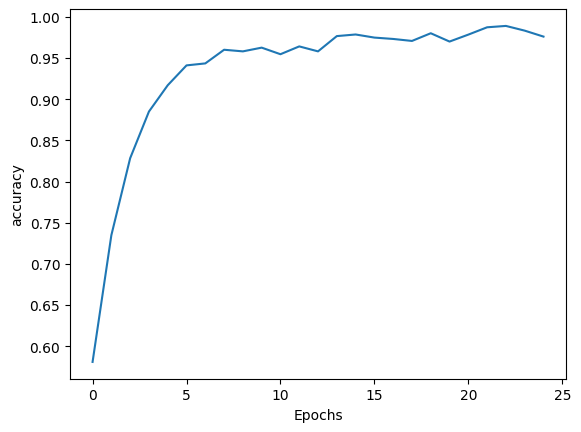

In [ ]:
plot_history(history, 'accuracy')

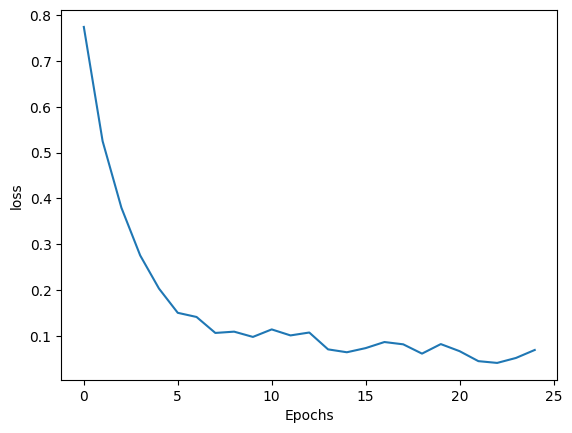

In [ ]:
plot_history(history, 'loss')

In [ ]:
result = model.evaluate(test_data)
print("Test loss, Test accuracy : ", result)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9681 - loss: 0.1090
Test loss, Test accuracy :  [0.07880094647407532, 0.9748252034187317]


Visualize predicted images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


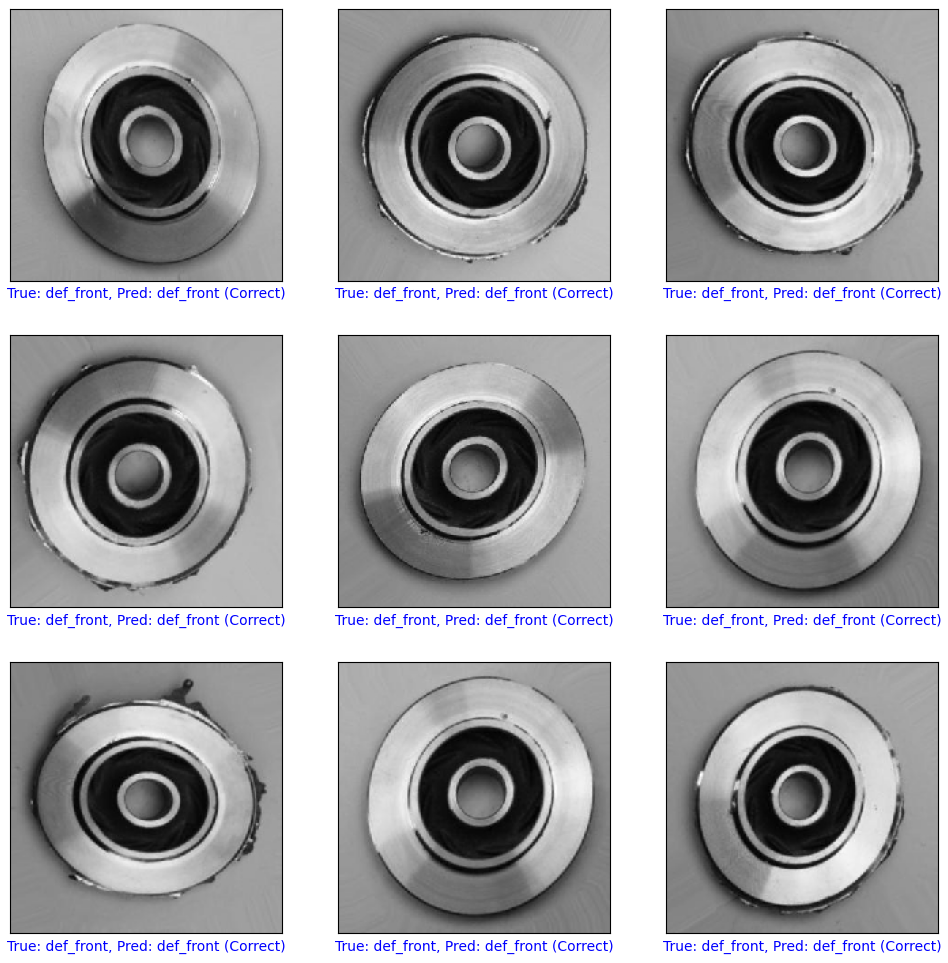

In [ ]:
images, labels = next(test_data)

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = model.predict(images)


class_names=list(test_data.class_indices.keys())


plt.figure(figsize=(12,12))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = images[i]

    if image.shape[-1] == 1:
        image = np.squeeze(image)

    plt.imshow(image)

    predicted_label = np.argmax(predictions[i])

    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"

    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"

    plt.xlabel(label_text,color=color)